### Loading NiFTI Files with Nilearn and NiBabel

In [1]:
import os
import nibabel as nib
from nilearn import image

def load_nifti(data_dir, subject, session, data_type, nii_format="img", nilearn_format="nifti"):
  """
  Loads a NiFTI file from the BIDS structure, returns images in specified formats,
  handles errors, and provides data loading using NiBabel.

  Args:
    data_dir: Root directory of the BIDS dataset (using forward slashes).
    subject: Subject ID (e.g., "sub-control01").
    session: Session ID (e.g., "ses-01").
    data_type: Type of data (e.g., "dwi", "anat").
    nii_format: Format to use for NiBabel ("img" or "vox").
    nilearn_format: Format to use for NiLearn ("nifti" or "nifti1").

  Returns:
    A tuple containing:
      - (Optional) NiBabel image object, or None if the file is not found.
      - (Optional) Nilearn image object, or None if the file is not found.
      - (Optional) Data from the NiBabel image, or None if loading fails.
      - A string describing any encountered errors (empty string if no error).
  """
  filename = os.path.join(data_dir, subject, session, data_type)

  # Check if directory exists for the given data type
  if not os.path.isdir(filename):
    error_message = f"Directory not found: {filename}"
    return None, None, None, error_message

  # Get the file name without extension
  file_name_without_ext = f"{subject}_{session}"
  file_path = None

  # Iterate over the files in the directory and find the matching file
  for file in os.listdir(filename):
    if file.startswith(file_name_without_ext) and file.endswith(".nii.gz"):
      file_path = os.path.join(filename, file)
      break

  if file_path is None:
    error_message = f"File not found: {file_name_without_ext}.nii.gz"
    return None, None, None, error_message

  try:
    img = nib.load(file_path)
    data = img.get_fdata() # Load data using NiBabel
    nilearn_img = image.load_img(file_path)
  except Exception as e:
    error_message = f"Error loading file: {file_name_without_ext}.nii.gz - {str(e)}"
    return None, None, None, error_message

  return img, nilearn_img, data, "" # Return loaded data


### Example Usage of the load_nifti Function

In [2]:
# Example usage
data_dir = "data/ds001378"
subject = "sub-control01"
session = "ses-01"
data_types = ["dwi", "anat"]

for data_type in data_types:
  # Load NiBabel, Nilearn images, and data, handling potential errors
  img, nilearn_img, data, error_message = load_nifti(data_dir, subject, session, data_type)

  if error_message:
    print(f"Error encountered: {error_message}")
  else:
    # Access data (if no errors)
    print(data.shape) # Example usage of the loaded data


(128, 128, 50, 16)
(256, 256, 160)


### Visualizing DWI Data for Control Subject #1

(128, 128, 50, 16)


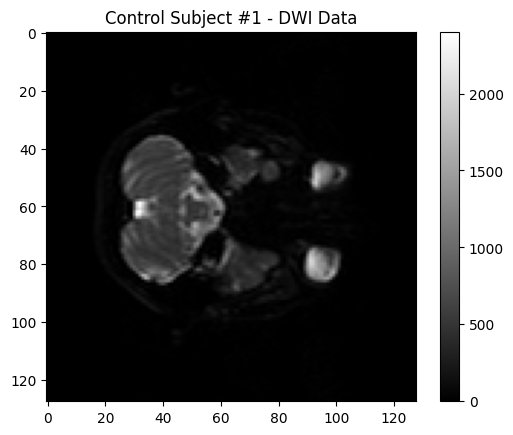

(256, 256, 160)


In [3]:
import matplotlib.pyplot as plt

for data_type in data_types:
    # Load NiBabel, Nilearn images, and data, handling potential errors
    img, nilearn_img, data, error_message = load_nifti(data_dir, subject, session, data_type)

    if error_message:
        print(f"Error encountered: {error_message}")
    else:
        # Access data (if no errors)
        print(data.shape)  # Example usage of the loaded data
        
        if data_type == "dwi":
            # Get the group and subject information
            group = "control"  # Replace with the appropriate variable for the group
            subject_id = 1  # Replace with the appropriate variable for the subject ID
            
            # Display the first volume in the DWI data
            plt.imshow(data[..., 0][:, :, data.shape[3] // 2], cmap="gray")
            plt.title(f"{group.capitalize()} Subject #{subject_id} - {data_type.upper()} Data")
            plt.colorbar()
            plt.show()


### Calculating and Visualizing Mean FA Differences

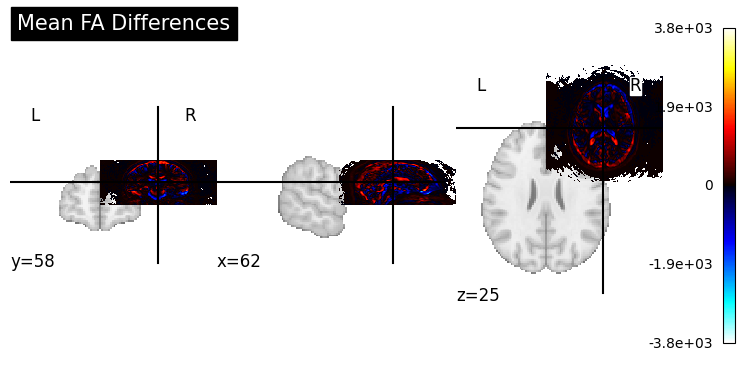

In [4]:
import nibabel as nib
import numpy as np
from nilearn import plotting

def calculate_mean_fa(subject, session1, session2):
    # Load FA data for session 1
    _, _, data1, error_message1 = load_nifti("data/ds001378", subject, session1, "dwi")
    if error_message1:
        print(f"Error loading data for {subject} in {session1}: {error_message1}")
        return None

    fa_data1 = data1[..., 0]  # Assuming FA is the first volume

    # Load FA data for session 2
    _, _, data2, error_message2 = load_nifti("data/ds001378", subject, session2, "dwi")
    if error_message2:
        print(f"Error loading data for {subject} in {session2}: {error_message2}")
        return None

    fa_data2 = data2[..., 0]  # Assuming FA is the first volume

    # Calculate the difference in FA between session 2 and session 1
    fa_diff = fa_data2 - fa_data1

    # Calculate the mean FA difference
    mean_fa_diff = np.mean(fa_diff)

    # Check if mean_fa_diff is not NaN
    if np.isnan(mean_fa_diff):
        print("Mean FA difference is NaN.")
        return None

    # Create a 3D Nifti image of the mean FA differences
    mean_fa_diff_image = nib.Nifti1Image(fa_diff, affine=np.eye(4))  # Set affine to identity matrix

    # Plot the mean FA differences using Nilearn
    plotting.plot_stat_map(mean_fa_diff_image, title="Mean FA Differences")

    return mean_fa_diff

# Define the values of subject, session1, and session2
subject = "sub-control01"
session1 = "ses-01"
session2 = "ses-02"

# Call the calculate_mean_fa() function
mean_fa_diff = calculate_mean_fa(subject, session1, session2)

# Check if mean_fa_diff is not None (indicating successful calculation)
if mean_fa_diff is not None:
    # Show the plot
    plt.show()


In the plot, the red-blue gradient represents the range of differences in fractional anisotropy (FA) values between session 2 and session 1. The red color indicates areas where FA values are higher in session 2 compared to session 1, while the blue color indicates areas where FA values are lower in session 2 compared to session 1.

The differences in FA values are computed voxel-wise, meaning that the difference is calculated for each voxel in the brain. For each voxel, the FA value from session 1 is subtracted from the FA value from session 2. This difference represents the change in FA between the two sessions at that specific voxel.

Positive differences (red zones) indicate an increase in FA values from session 1 to session 2. This suggests that there has been an increase in white matter integrity or organization in those areas. It could be due to various factors such as learning, neuroplasticity, or treatment effects.

Negative differences (blue zones) indicate a decrease in FA values from session 1 to session 2. This suggests a reduction in white matter integrity or organization in those areas. It could be associated with factors such as neurodegeneration, injury, or disease progression.

### Calculating and Visualizing FA Difference Maps

In [5]:
import numpy as np
from scipy import stats
import pandas as pd
import nibabel as nib
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.reconst import dti
from dipy.reconst.dti import fractional_anisotropy

def calculate_fa_diff_map(subject, session1, session2):
    # Load bval and bvec files for session 1
    bvals1, bvecs1 = read_bvals_bvecs(f"data/ds001378/{subject}/{session1}/dwi/{subject}_{session1}_dwi.bval",
                                       f"data/ds001378/{subject}/{session1}/dwi/{subject}_{session1}_dwi.bvec")

    # Load bval and bvec files for session 2
    bvals2, bvecs2 = read_bvals_bvecs(f"data/ds001378/{subject}/{session2}/dwi/{subject}_{session2}_dwi.bval",
                                       f"data/ds001378/{subject}/{session2}/dwi/{subject}_{session2}_dwi.bvec")

    # Load DWI data for session 1
    dwi1 = nib.load(f"data/ds001378/{subject}/{session1}/dwi/{subject}_{session1}_dwi.nii.gz").get_fdata()

    # Load DWI data for session 2
    dwi2 = nib.load(f"data/ds001378/{subject}/{session2}/dwi/{subject}_{session2}_dwi.nii.gz").get_fdata()

    # Create gradient tables for session 1 and session 2
    gtab1 = gradient_table(bvals1, bvecs1)
    gtab2 = gradient_table(bvals2, bvecs2)

    # Calculate FA for session 1
    tensor_model1 = dti.TensorModel(gtab1)
    tensor_fit1 = tensor_model1.fit(dwi1)
    fa1 = fractional_anisotropy(tensor_fit1.evals)

    # Calculate FA for session 2
    tensor_model2 = dti.TensorModel(gtab2)
    tensor_fit2 = tensor_model2.fit(dwi2)
    fa2 = fractional_anisotropy(tensor_fit2.evals)

    # Calculate the difference in FA between session 2 and session 1
    fa_diff = fa2 - fa1

    return fa_diff

# Define the values of session1 and session2
session1 = "ses-01"
session2 = "ses-02"

# Define a list of subjects
subjects = ["sub-control01", "sub-SCA201"]

# Create empty lists to store the results
subject_list = []
fa_diff_maps = []

# Iterate over each subject
for subject in subjects:
    # Call the calculate_fa_diff_map() function
    fa_diff_map = calculate_fa_diff_map(subject, session1, session2)

    # Append the results to the lists, ensuring consistent lengths
    num_voxels = np.prod(fa_diff_map.shape)  # Calculate number of voxels
    subject_list.extend([subject] * num_voxels)
    fa_diff_maps.append(fa_diff_map)

# Combine the fa_diff_maps into a single array
fa_diff_maps = np.stack(fa_diff_maps, axis=0)

# Perform voxel-wise t-test using scipy
t_values, _ = stats.ttest_1samp(fa_diff_maps, 0, axis=0)

# Reshape t_values to match the shape of fa_diff_map
t_values_reshaped = t_values.reshape(fa_diff_maps.shape[1:])

# Print the shapes of t_values and t_values_reshaped for verification (optional)
print("t_values shape:", t_values.shape)
print("t_values_reshaped shape:", t_values_reshaped.shape)

# Save the t-values as a NIfTI image
t_values


C:\Users\gabo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


t_values shape: (128, 128, 50)
t_values_reshaped shape: (128, 128, 50)


array([[[nan,  1., nan, ..., nan, nan, nan],
        [ 1.,  1., nan, ..., nan, nan, nan],
        [ 1., nan, nan, ..., nan, nan, nan],
        ...,
        [ 1., -1., -1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1., nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [ 1., nan, nan, ..., nan, nan, nan],
        [ 1.,  1., nan, ..., nan, nan, nan],
        ...,
        [nan, -1., -1., ..., nan, nan, nan],
        [nan, nan, -1., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, -1., ..., nan, nan, nan],
        [ 1.,  1., nan, ..., nan, nan, nan],
        [nan,  1., nan, ..., nan, nan, nan],
        ...,
        [-1.,  1.,  1., ..., nan, nan, nan],
        [-1., -1., nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

### Visualizing Significant Voxels Heatmap

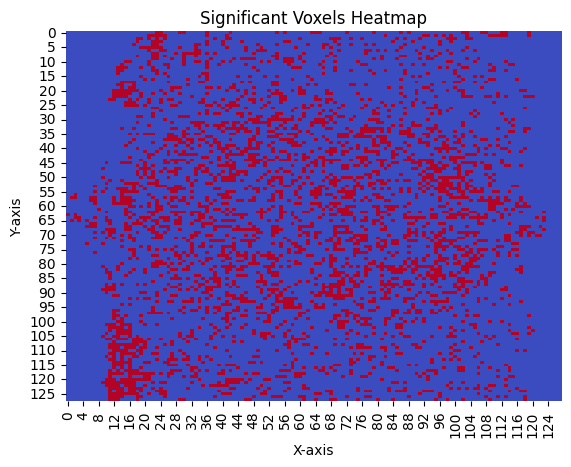

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a slice of the t_values_reshaped array (e.g., the first slice along the z-axis)
t_slice = t_values_reshaped[:, :, 0]

# Create a binary mask indicating significant voxels based on a threshold
threshold = 2.0
significant_mask = np.abs(t_slice) >= threshold

# Create a heatmap of the significant voxels
sns.heatmap(significant_mask, cmap='coolwarm', cbar=False)

# Set the axis labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Set the plot title
plt.title('Significant Voxels Heatmap')

# Display the plot
plt.show()


### Training and Evaluating Random Forest Classifier

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import nibabel as nib

# Define the load_nifti function
def load_nifti(data_dir, subject, session, modality):
    file_path = f"{data_dir}/{subject}/{session}/{modality}/{subject}_{session}_{modality}.nii.gz"
    nifti_image = nib.load(file_path)
    data = nifti_image.get_fdata()
    return data

# Define the control_subjects and sca2_subjects variables
control_subjects = ["sub-control{:02d}".format(i) for i in range(1, 17)]
sca2_subjects = ["sub-sca2{:02d}".format(i) for i in range(1, 10)]

# Load FA maps for both sessions and subjects
control_fa_maps1 = []
control_fa_maps2 = []
sca2_fa_maps1 = []
sca2_fa_maps2 = []

for subject in control_subjects:
    fa_data1 = load_nifti("data/ds001378", subject, "ses-01", "dwi")
    fa_data2 = load_nifti("data/ds001378", subject, "ses-02", "dwi")
    control_fa_maps1.append(fa_data1)
    control_fa_maps2.append(fa_data2)

for subject in sca2_subjects:
    # Load FA data for both sessions (ses-01 and ses-02) for SCA2 subjects
    sca2_fa_data1 = load_nifti("data/ds001378", subject, "ses-01", "dwi")
    sca2_fa_data2 = load_nifti("data/ds001378", subject, "ses-02", "dwi")
    
    # Exclude subjects with mismatched shapes
    if sca2_fa_data1.shape == sca2_fa_data2.shape:
        sca2_fa_maps1.append(sca2_fa_data1)
        sca2_fa_maps2.append(sca2_fa_data2)

# Element-wise FA difference calculations
control_fa_diffs = np.array([np.abs(fa1 - fa2) for fa1, fa2 in zip(control_fa_maps1, control_fa_maps2)])
sca2_fa_diffs = np.array([np.abs(fa1 - fa2) for fa1, fa2 in zip(sca2_fa_maps1, sca2_fa_maps2)])

# Combine features and labels
features = np.concatenate([
    control_fa_diffs.reshape(-1, np.prod(control_fa_diffs[0].shape)),
    sca2_fa_diffs.reshape(-1, np.prod(sca2_fa_diffs[0].shape))
])
labels = np.concatenate([np.zeros(len(control_subjects)), np.ones(len(sca2_fa_maps1))])

# Debugging: Print the shapes of features and labels
print("Shape of features:", features.shape)
print("Shape of labels:", labels.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=None)

# Debugging: Check the class distribution in the train and test sets
print("Train class distribution:", np.bincount(y_train.astype(int)))
print("Test class distribution:", np.bincount(y_test.astype(int)))

# Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=None)
clf.fit(X_train, y_train)

# Evaluate
accuracy = clf.score(X_test, y_test)
print(f"Accuracy on test set: {accuracy:.4f}")


Shape of features: (24, 13107200)
Shape of labels: (24,)
Train class distribution: [12  7]
Test class distribution: [4 1]
Accuracy on test set: 0.8000


### Training and Evaluating Convolutional Neural Network Classifier

In [8]:
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
import nibabel as nib
from tensorflow.keras.utils import plot_model

# Define the load_nifti function
def load_nifti(data_dir, subject, session, modality):
    file_path = f"{data_dir}/{subject}/{session}/{modality}/{subject}_{session}_{modality}.nii.gz"
    nifti_image = nib.load(file_path)
    data = nifti_image.get_fdata()
    return data

# Define the control_subjects and sca2_subjects variables
control_subjects = ["sub-control{:02d}".format(i) for i in range(1, 17)]
sca2_subjects = ["sub-sca2{:02d}".format(i) for i in range(1, 10)]

# Load FA maps for both sessions and subjects
control_fa_maps1 = []
control_fa_maps2 = []
sca2_fa_maps1 = []
sca2_fa_maps2 = []

for subject in control_subjects:
    fa_data1 = load_nifti("data/ds001378", subject, "ses-01", "dwi")
    fa_data2 = load_nifti("data/ds001378", subject, "ses-02", "dwi")
    control_fa_maps1.append(fa_data1)
    control_fa_maps2.append(fa_data2)

for subject in sca2_subjects:
    fa_data1 = load_nifti("data/ds001378", subject, "ses-01", "dwi")
    fa_data2 = load_nifti("data/ds001378", subject, "ses-02", "dwi")
    sca2_fa_maps1.append(fa_data1)
    sca2_fa_maps2.append(fa_data2)

# Combine control and SCA2 data
X = []
y = []

# Resize and append the FA maps
for fa_map in control_fa_maps1:
    resized_map = resize(fa_map, (64, 64, 50))
    if resized_map.shape == (64, 64, 50):
        X.append(resized_map)
        y.append(0)

for fa_map in control_fa_maps2:
    resized_map = resize(fa_map, (64, 64, 50))
    if resized_map.shape == (64, 64, 50):
        X.append(resized_map)
        y.append(0)

for fa_map in sca2_fa_maps1:
    resized_map = resize(fa_map, (64, 64, 50))
    if resized_map.shape == (64, 64, 50):
        X.append(resized_map)
        y.append(1)

for fa_map in sca2_fa_maps2:
    resized_map = resize(fa_map, (64, 64, 50))
    if resized_map.shape == (64, 64, 50):
        X.append(resized_map)
        y.append(1)

# Convert X and y to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# Reshape X to add a channel dimension
X = X[..., np.newaxis]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the CNN model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=X_train[0].shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Save the model architecture diagram to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.